In [1]:
#!pip install captcha

In [2]:
import tensorflow as tf
from captcha.image import ImageCaptcha
import  matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import string
import os
import pathlib
from functools import partial


In [3]:
all_characters = string.ascii_letters + string.digits
captcha_dir = 'captcha_images'
captcha_dir = pathlib.Path(os.path.abspath(captcha_dir))

captcha_len = 4
vocab = list(all_characters)
vocab_len = len(vocab)
batch_size = 1024
img_height = 60
img_width = 160

In [4]:
def generate_captcha(size=captcha_len, all_characters=all_characters):
    text = random.choices(all_characters, k=size)
    image_captcha = ImageCaptcha()
    captcha = image_captcha.generate(text)
    return captcha, text

def show_captcha():
    captcha, text = generate_captcha()
    captcha_image = Image.open(captcha)
    plt.imshow(captcha_image)


def get_captacha_array(num_captcha=1000):
    num = 0
    while num <= num_captcha:
        captcha, text = generate_captcha()
        captcha_image = Image.open(captcha)
        captcha_image = captcha_image.resize(img_height, img_width)
        captcha_array = np.array(captcha_image)
        num += 1
        yield captcha_array, text   

def save_captcha(img_dir, num=1000):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    for i in range(num):
        all_images = captcha_dir.glob('*/*.jpg')
        img_names = (img.name for img in all_images)
        captcha, text = generate_captcha()
        captcha_image = Image.open(captcha)  
        img_name = ''.join(text)+'.jpg'
        if img_name not in img_names:
            img_path = os.path.join(img_dir, img_name)
            captcha_image.save(img_path)
            
def generate_captchas(img_type, num=1000):
    img_dir = os.path.join(captcha_dir, img_type)
    save_captcha(img_dir=img_dir, num=num) 
    
    

In [5]:
# 用于创建数据集 -- 训练集，验证集，测试集
# 数据集大小自定义
# for i in range(20):
    # generate_captchas('train', 3000)
    # generate_captchas('val')
    # generate_captchas('test')

In [6]:
def text2vec(text):
    vector = np.zeros((vocab_len,))
    for i, c in enumerate(text):
        index = vocab.index(c)
        vector[index] = 1
    return vector


def vec2text(vector):
    text = ''
    text += vocab[np.argmax(vector)]
    return text



In [20]:
def load_image(img_type):
    images= captcha_dir.glob(img_type +'/*.jpg')
    all_img_path = []
    c0s = []
    c1s = []
    c2s = []
    c3s = []
    locals_ = locals()
    for image in images:
        text = image.name.split('.')[0]
        all_img_path.append(str(image))
        for i in range(captcha_len):        
            locals_['c' + str(i) + 's'].append(text2vec(text[i]))
    return all_img_path, c0s, c1s, c2s, c3s

def decode_image(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [60, 160])
    return img

def preprocess_dataset(img, c_s, img_type):
    img = decode_image(img) 
    img = img / 255.0
    return img, c_s #tf.reshape(text, [captcha_len*vocab_len, ])

def load_dataset_from_slices(img_type):
    all_img_path, c0s, c1s, c2s, c3s = load_image(img_type)
    return tf.data.Dataset.from_tensor_slices((all_img_path, (c0s, c1s, c2s, c3s)))
    

def load_dataset(img_type):
    dataset = load_dataset_from_slices(img_type)  
    preprocess_dataset_ = partial(preprocess_dataset, img_type=img_type)
    dataset = dataset.map(preprocess_dataset_)
    dataset = dataset.cache().batch(batch_size)
    return dataset
    

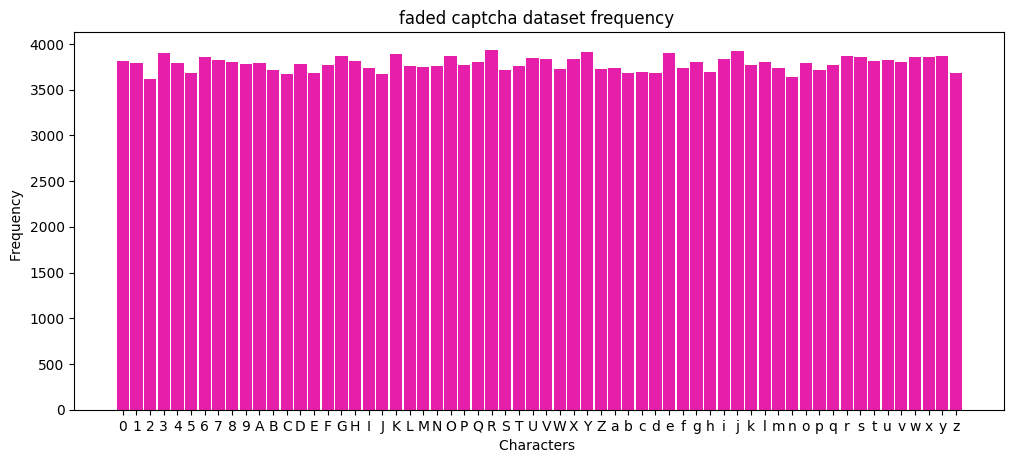

In [8]:
all_paths, c0s, c1s, c2s, c3s = load_image('train')
indexes = {}
for c_s in [c0s, c1s, c2s, c3s]:
    for c in c_s:
        c = vec2text(c)
        c_count = indexes.get(c, 0)
        indexes[c] = c_count + 1

from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(sorted(indexes.keys()), indexes.values(), width=0.9, color='#e61faa')
plt.title('faded captcha dataset frequency ')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
#plt.xticks(fontsize=14)  
#plt.yticks(fontsize=14)
plt.show()

(1024, 60, 160, 3) (1024, 62)
(60, 160, 3) (62,)


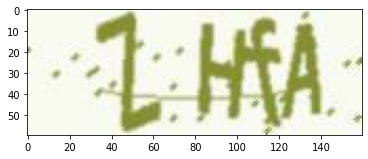

In [9]:
for images, c_s in load_dataset('train').take(1):
    print(images.shape, c_s[0].shape)
    print(images[0].shape, c1s[0].shape)
    plt.imshow(images[0].numpy())
    break
    

In [10]:
train_dataset = load_dataset('train')
val_dataset = load_dataset('val')

In [11]:
def make_model():
    inputs = tf.keras.layers.Input(shape=[60, 160, 3])
    x = inputs
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = []
    for i in range(captcha_len):
        dens1 = tf.keras.layers.Dense(64, activation='relu')(x)
        drop = tf.keras.layers.Dropout(0.5)(dens1)
        res = tf.keras.layers.Dense(vocab_len, activation='softmax')(drop)
        outputs.append(res)
        
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model
    



In [12]:
model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 160, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 160, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 80, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 80, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

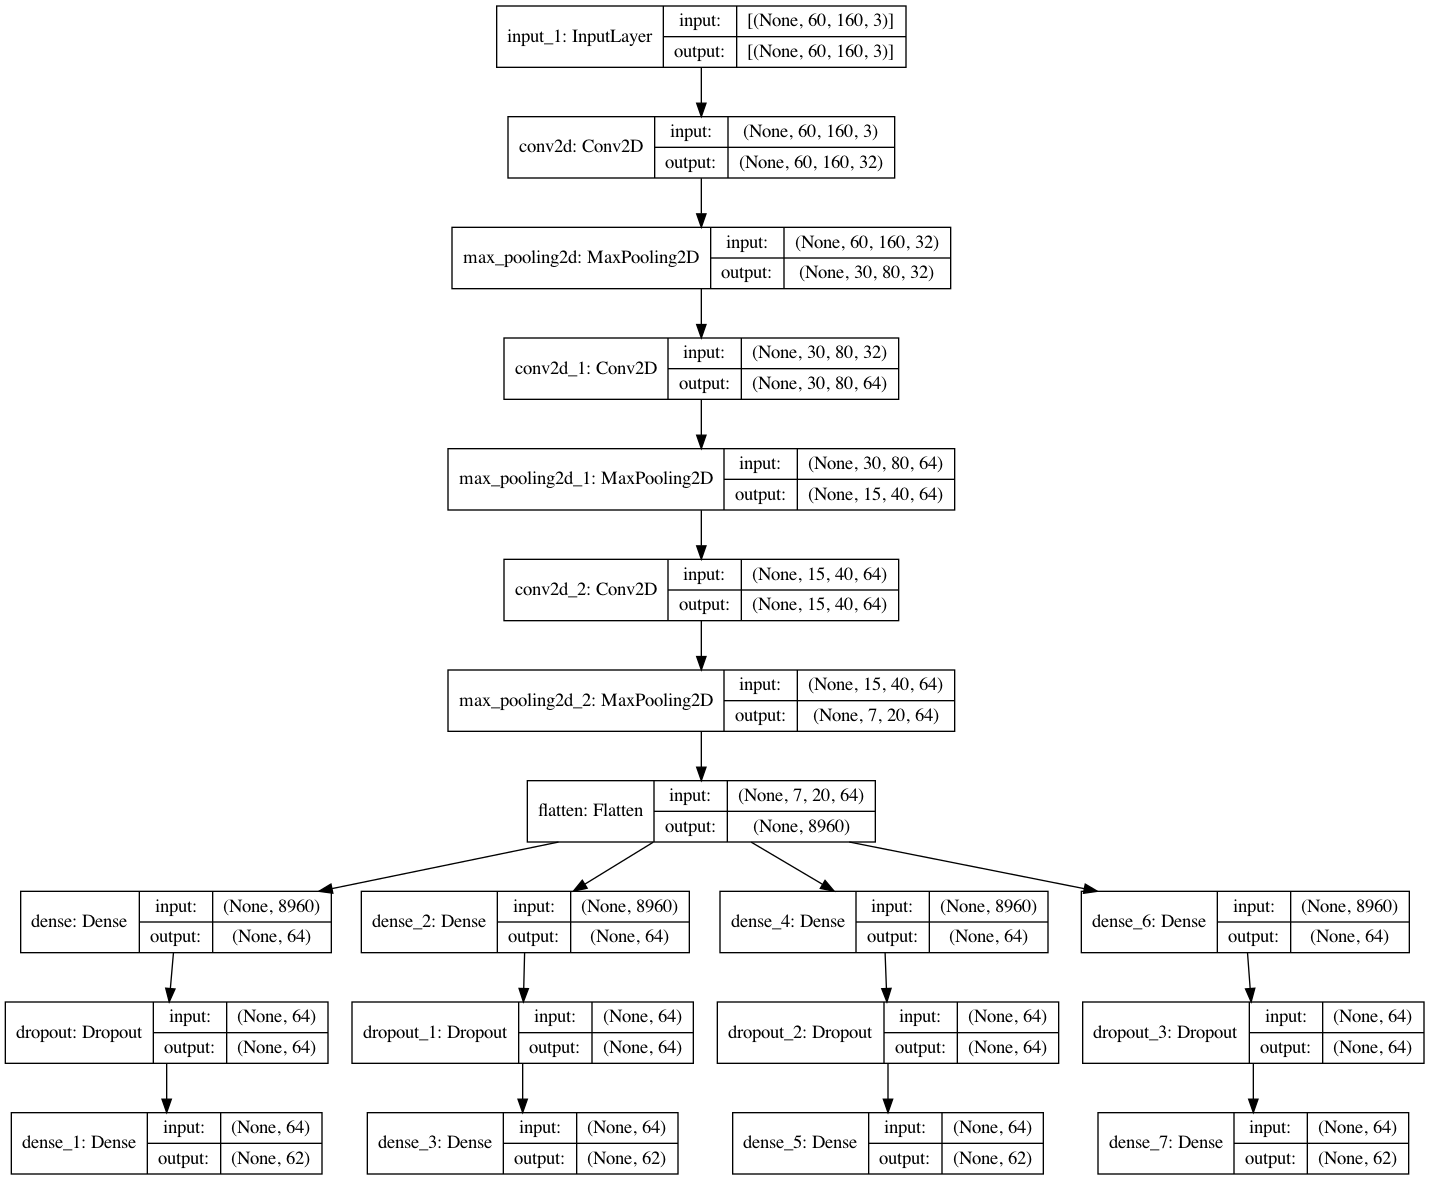

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True)


In [14]:
epochs = 100
callback_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='captcha_identify.h5', monitor='val_acc', save_best_only=True)
]

def model_fit(model, train_dataset):
    history = model.fit(train_dataset,
         epochs=epochs,
         validation_data=val_dataset,
         callbacks=callback_list)
    return history

history = model_fit(model, train_dataset)

Epoch 1/100
58/58 [==============================] - 457s 8s/step - loss: 16.5304 - dense_1_loss: 4.1313 - dense_3_loss: 4.1331 - dense_5_loss: 4.1332 - dense_7_loss: 4.1327 - dense_1_accuracy: 0.0156 - dense_3_accuracy: 0.0164 - dense_5_accuracy: 0.0170 - dense_7_accuracy: 0.0157 - val_loss: 16.5083 - val_dense_1_loss: 4.1274 - val_dense_3_loss: 4.1272 - val_dense_5_loss: 4.1268 - val_dense_7_loss: 4.1270 - val_dense_1_accuracy: 0.0200 - val_dense_3_accuracy: 0.0180 - val_dense_5_accuracy: 0.0200 - val_dense_7_accuracy: 0.0140
Epoch 2/100
58/58 [==============================] - 437s 7s/step - loss: 16.5071 - dense_1_loss: 4.1267 - dense_3_loss: 4.1268 - dense_5_loss: 4.1268 - dense_7_loss: 4.1268 - dense_1_accuracy: 0.0177 - dense_3_accuracy: 0.0166 - dense_5_accuracy: 0.0191 - dense_7_accuracy: 0.0181 - val_loss: 16.5027 - val_dense_1_loss: 4.1238 - val_dense_3_loss: 4.1267 - val_dense_5_loss: 4.1266 - val_dense_7_loss: 4.1257 - val_dense_1_accuracy: 0.0200 - val_dense_3_accuracy: 0

58/58 [==============================] - 489s 8s/step - loss: 11.0212 - dense_1_loss: 2.2056 - dense_3_loss: 3.1453 - dense_5_loss: 3.1387 - dense_7_loss: 2.5316 - dense_1_accuracy: 0.3213 - dense_3_accuracy: 0.1596 - dense_5_accuracy: 0.1662 - dense_7_accuracy: 0.2480 - val_loss: 8.3610 - val_dense_1_loss: 1.4053 - val_dense_3_loss: 2.6403 - val_dense_5_loss: 2.5937 - val_dense_7_loss: 1.7218 - val_dense_1_accuracy: 0.6030 - val_dense_3_accuracy: 0.3670 - val_dense_5_accuracy: 0.3630 - val_dense_7_accuracy: 0.5560
Epoch 10/100
58/58 [==============================] - 396s 7s/step - loss: 10.8368 - dense_1_loss: 2.1684 - dense_3_loss: 3.1065 - dense_5_loss: 3.0942 - dense_7_loss: 2.4677 - dense_1_accuracy: 0.3285 - dense_3_accuracy: 0.1660 - dense_5_accuracy: 0.1725 - dense_7_accuracy: 0.2613 - val_loss: 8.2291 - val_dense_1_loss: 1.3365 - val_dense_3_loss: 2.6358 - val_dense_5_loss: 2.5903 - val_dense_7_loss: 1.6665 - val_dense_1_accuracy: 0.6170 - val_dense_3_accuracy: 0.3560 - val_d

58/58 [==============================] - 364s 6s/step - loss: 10.0468 - dense_1_loss: 1.9120 - dense_3_loss: 2.9598 - dense_5_loss: 2.9300 - dense_7_loss: 2.2450 - dense_1_accuracy: 0.3850 - dense_3_accuracy: 0.1901 - dense_5_accuracy: 0.2071 - dense_7_accuracy: 0.3028 - val_loss: 7.1852 - val_dense_1_loss: 1.0570 - val_dense_3_loss: 2.4216 - val_dense_5_loss: 2.3557 - val_dense_7_loss: 1.3509 - val_dense_1_accuracy: 0.6760 - val_dense_3_accuracy: 0.3910 - val_dense_5_accuracy: 0.4170 - val_dense_7_accuracy: 0.6170
Epoch 18/100
58/58 [==============================] - 354s 6s/step - loss: 9.9690 - dense_1_loss: 1.8946 - dense_3_loss: 2.9312 - dense_5_loss: 2.9187 - dense_7_loss: 2.2245 - dense_1_accuracy: 0.3898 - dense_3_accuracy: 0.1934 - dense_5_accuracy: 0.2088 - dense_7_accuracy: 0.3100 - val_loss: 7.1692 - val_dense_1_loss: 1.0588 - val_dense_3_loss: 2.4082 - val_dense_5_loss: 2.3449 - val_dense_7_loss: 1.3574 - val_dense_1_accuracy: 0.6720 - val_dense_3_accuracy: 0.3950 - val_de

58/58 [==============================] - 373s 6s/step - loss: 9.6337 - dense_1_loss: 1.7820 - dense_3_loss: 2.8777 - dense_5_loss: 2.8339 - dense_7_loss: 2.1401 - dense_1_accuracy: 0.4142 - dense_3_accuracy: 0.2040 - dense_5_accuracy: 0.2234 - dense_7_accuracy: 0.3346 - val_loss: 6.6905 - val_dense_1_loss: 0.9181 - val_dense_3_loss: 2.3076 - val_dense_5_loss: 2.2160 - val_dense_7_loss: 1.2489 - val_dense_1_accuracy: 0.7180 - val_dense_3_accuracy: 0.4220 - val_dense_5_accuracy: 0.4650 - val_dense_7_accuracy: 0.6430
Epoch 26/100
58/58 [==============================] - 362s 6s/step - loss: 9.5660 - dense_1_loss: 1.7716 - dense_3_loss: 2.8610 - dense_5_loss: 2.8116 - dense_7_loss: 2.1217 - dense_1_accuracy: 0.4210 - dense_3_accuracy: 0.2076 - dense_5_accuracy: 0.2301 - dense_7_accuracy: 0.3357 - val_loss: 6.7040 - val_dense_1_loss: 0.9319 - val_dense_3_loss: 2.3071 - val_dense_5_loss: 2.2273 - val_dense_7_loss: 1.2377 - val_dense_1_accuracy: 0.7180 - val_dense_3_accuracy: 0.4140 - val_den

58/58 [==============================] - 375s 6s/step - loss: 9.3441 - dense_1_loss: 1.6960 - dense_3_loss: 2.8184 - dense_5_loss: 2.7524 - dense_7_loss: 2.0773 - dense_1_accuracy: 0.4416 - dense_3_accuracy: 0.2136 - dense_5_accuracy: 0.2403 - dense_7_accuracy: 0.3414 - val_loss: 6.3908 - val_dense_1_loss: 0.8520 - val_dense_3_loss: 2.2412 - val_dense_5_loss: 2.1363 - val_dense_7_loss: 1.1614 - val_dense_1_accuracy: 0.7310 - val_dense_3_accuracy: 0.4440 - val_dense_5_accuracy: 0.4670 - val_dense_7_accuracy: 0.6660
Epoch 34/100
58/58 [==============================] - 374s 6s/step - loss: 9.3152 - dense_1_loss: 1.6905 - dense_3_loss: 2.8102 - dense_5_loss: 2.7566 - dense_7_loss: 2.0579 - dense_1_accuracy: 0.4339 - dense_3_accuracy: 0.2146 - dense_5_accuracy: 0.2408 - dense_7_accuracy: 0.3490 - val_loss: 6.3260 - val_dense_1_loss: 0.8215 - val_dense_3_loss: 2.2435 - val_dense_5_loss: 2.1186 - val_dense_7_loss: 1.1423 - val_dense_1_accuracy: 0.7350 - val_dense_3_accuracy: 0.4440 - val_den

58/58 [==============================] - 338s 6s/step - loss: 9.1553 - dense_1_loss: 1.6392 - dense_3_loss: 2.7887 - dense_5_loss: 2.7053 - dense_7_loss: 2.0222 - dense_1_accuracy: 0.4568 - dense_3_accuracy: 0.2210 - dense_5_accuracy: 0.2515 - dense_7_accuracy: 0.3524 - val_loss: 6.2087 - val_dense_1_loss: 0.7984 - val_dense_3_loss: 2.1968 - val_dense_5_loss: 2.0879 - val_dense_7_loss: 1.1256 - val_dense_1_accuracy: 0.7430 - val_dense_3_accuracy: 0.4540 - val_dense_5_accuracy: 0.4720 - val_dense_7_accuracy: 0.6800
Epoch 42/100
58/58 [==============================] - 354s 6s/step - loss: 9.1195 - dense_1_loss: 1.6377 - dense_3_loss: 2.7759 - dense_5_loss: 2.7009 - dense_7_loss: 2.0051 - dense_1_accuracy: 0.4538 - dense_3_accuracy: 0.2260 - dense_5_accuracy: 0.2487 - dense_7_accuracy: 0.3656 - val_loss: 6.0937 - val_dense_1_loss: 0.7846 - val_dense_3_loss: 2.1578 - val_dense_5_loss: 2.0548 - val_dense_7_loss: 1.0965 - val_dense_1_accuracy: 0.7520 - val_dense_3_accuracy: 0.4570 - val_den

58/58 [==============================] - 361s 6s/step - loss: 8.9922 - dense_1_loss: 1.6048 - dense_3_loss: 2.7459 - dense_5_loss: 2.6632 - dense_7_loss: 1.9783 - dense_1_accuracy: 0.4644 - dense_3_accuracy: 0.2265 - dense_5_accuracy: 0.2579 - dense_7_accuracy: 0.3692 - val_loss: 6.0742 - val_dense_1_loss: 0.7874 - val_dense_3_loss: 2.1530 - val_dense_5_loss: 2.0361 - val_dense_7_loss: 1.0978 - val_dense_1_accuracy: 0.7510 - val_dense_3_accuracy: 0.4570 - val_dense_5_accuracy: 0.4950 - val_dense_7_accuracy: 0.6840
Epoch 50/100
58/58 [==============================] - 348s 6s/step - loss: 8.9859 - dense_1_loss: 1.6086 - dense_3_loss: 2.7313 - dense_5_loss: 2.6618 - dense_7_loss: 1.9843 - dense_1_accuracy: 0.4644 - dense_3_accuracy: 0.2320 - dense_5_accuracy: 0.2580 - dense_7_accuracy: 0.3641 - val_loss: 6.0316 - val_dense_1_loss: 0.7790 - val_dense_3_loss: 2.1343 - val_dense_5_loss: 2.0461 - val_dense_7_loss: 1.0722 - val_dense_1_accuracy: 0.7600 - val_dense_3_accuracy: 0.4650 - val_den

58/58 [==============================] - 349s 6s/step - loss: 8.8848 - dense_1_loss: 1.5689 - dense_3_loss: 2.7240 - dense_5_loss: 2.6420 - dense_7_loss: 1.9499 - dense_1_accuracy: 0.4733 - dense_3_accuracy: 0.2320 - dense_5_accuracy: 0.2623 - dense_7_accuracy: 0.3751 - val_loss: 5.9174 - val_dense_1_loss: 0.7612 - val_dense_3_loss: 2.1001 - val_dense_5_loss: 1.9945 - val_dense_7_loss: 1.0616 - val_dense_1_accuracy: 0.7550 - val_dense_3_accuracy: 0.4770 - val_dense_5_accuracy: 0.5010 - val_dense_7_accuracy: 0.6910
Epoch 58/100
58/58 [==============================] - 344s 6s/step - loss: 8.8728 - dense_1_loss: 1.5683 - dense_3_loss: 2.7138 - dense_5_loss: 2.6359 - dense_7_loss: 1.9548 - dense_1_accuracy: 0.4765 - dense_3_accuracy: 0.2383 - dense_5_accuracy: 0.2618 - dense_7_accuracy: 0.3739 - val_loss: 5.8449 - val_dense_1_loss: 0.7374 - val_dense_3_loss: 2.0832 - val_dense_5_loss: 1.9969 - val_dense_7_loss: 1.0275 - val_dense_1_accuracy: 0.7740 - val_dense_3_accuracy: 0.4780 - val_den

58/58 [==============================] - 404s 7s/step - loss: 8.6960 - dense_1_loss: 1.5329 - dense_3_loss: 2.6930 - dense_5_loss: 2.6034 - dense_7_loss: 1.8668 - dense_1_accuracy: 0.4853 - dense_3_accuracy: 0.2400 - dense_5_accuracy: 0.2721 - dense_7_accuracy: 0.3984 - val_loss: 5.7229 - val_dense_1_loss: 0.7141 - val_dense_3_loss: 2.0701 - val_dense_5_loss: 1.9610 - val_dense_7_loss: 0.9777 - val_dense_1_accuracy: 0.7690 - val_dense_3_accuracy: 0.4860 - val_dense_5_accuracy: 0.5070 - val_dense_7_accuracy: 0.7170
Epoch 66/100
58/58 [==============================] - 430s 7s/step - loss: 8.6794 - dense_1_loss: 1.5234 - dense_3_loss: 2.6976 - dense_5_loss: 2.6073 - dense_7_loss: 1.8511 - dense_1_accuracy: 0.4840 - dense_3_accuracy: 0.2372 - dense_5_accuracy: 0.2716 - dense_7_accuracy: 0.4027 - val_loss: 5.6961 - val_dense_1_loss: 0.7080 - val_dense_3_loss: 2.0562 - val_dense_5_loss: 1.9683 - val_dense_7_loss: 0.9637 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.4880 - val_den

58/58 [==============================] - 381s 7s/step - loss: 8.5690 - dense_1_loss: 1.5137 - dense_3_loss: 2.6509 - dense_5_loss: 2.5813 - dense_7_loss: 1.8230 - dense_1_accuracy: 0.4871 - dense_3_accuracy: 0.2497 - dense_5_accuracy: 0.2755 - dense_7_accuracy: 0.4079 - val_loss: 5.5431 - val_dense_1_loss: 0.6918 - val_dense_3_loss: 2.0123 - val_dense_5_loss: 1.9326 - val_dense_7_loss: 0.9064 - val_dense_1_accuracy: 0.7750 - val_dense_3_accuracy: 0.4870 - val_dense_5_accuracy: 0.5170 - val_dense_7_accuracy: 0.7280
Epoch 74/100
58/58 [==============================] - 388s 7s/step - loss: 8.5799 - dense_1_loss: 1.5055 - dense_3_loss: 2.6579 - dense_5_loss: 2.5962 - dense_7_loss: 1.8203 - dense_1_accuracy: 0.4873 - dense_3_accuracy: 0.2466 - dense_5_accuracy: 0.2713 - dense_7_accuracy: 0.4072 - val_loss: 5.5389 - val_dense_1_loss: 0.6942 - val_dense_3_loss: 2.0201 - val_dense_5_loss: 1.9197 - val_dense_7_loss: 0.9050 - val_dense_1_accuracy: 0.7720 - val_dense_3_accuracy: 0.4880 - val_den

58/58 [==============================] - 424s 7s/step - loss: 8.4550 - dense_1_loss: 1.4816 - dense_3_loss: 2.6284 - dense_5_loss: 2.5518 - dense_7_loss: 1.7932 - dense_1_accuracy: 0.4974 - dense_3_accuracy: 0.2549 - dense_5_accuracy: 0.2843 - dense_7_accuracy: 0.4154 - val_loss: 5.4384 - val_dense_1_loss: 0.6793 - val_dense_3_loss: 1.9873 - val_dense_5_loss: 1.8869 - val_dense_7_loss: 0.8848 - val_dense_1_accuracy: 0.7750 - val_dense_3_accuracy: 0.4890 - val_dense_5_accuracy: 0.5360 - val_dense_7_accuracy: 0.7430
Epoch 82/100
58/58 [==============================] - 442s 8s/step - loss: 8.4036 - dense_1_loss: 1.4793 - dense_3_loss: 2.6078 - dense_5_loss: 2.5295 - dense_7_loss: 1.7871 - dense_1_accuracy: 0.4961 - dense_3_accuracy: 0.2587 - dense_5_accuracy: 0.2884 - dense_7_accuracy: 0.4126 - val_loss: 5.4232 - val_dense_1_loss: 0.6769 - val_dense_3_loss: 1.9807 - val_dense_5_loss: 1.8838 - val_dense_7_loss: 0.8818 - val_dense_1_accuracy: 0.7670 - val_dense_3_accuracy: 0.4910 - val_den

58/58 [==============================] - 378s 6s/step - loss: 8.3681 - dense_1_loss: 1.4604 - dense_3_loss: 2.6013 - dense_5_loss: 2.5236 - dense_7_loss: 1.7828 - dense_1_accuracy: 0.5076 - dense_3_accuracy: 0.2603 - dense_5_accuracy: 0.2894 - dense_7_accuracy: 0.4160 - val_loss: 5.3966 - val_dense_1_loss: 0.6695 - val_dense_3_loss: 1.9715 - val_dense_5_loss: 1.8864 - val_dense_7_loss: 0.8692 - val_dense_1_accuracy: 0.7790 - val_dense_3_accuracy: 0.5000 - val_dense_5_accuracy: 0.5440 - val_dense_7_accuracy: 0.7220
Epoch 90/100
58/58 [==============================] - 383s 7s/step - loss: 8.3350 - dense_1_loss: 1.4554 - dense_3_loss: 2.5981 - dense_5_loss: 2.5159 - dense_7_loss: 1.7656 - dense_1_accuracy: 0.5066 - dense_3_accuracy: 0.2611 - dense_5_accuracy: 0.2903 - dense_7_accuracy: 0.4201 - val_loss: 5.3855 - val_dense_1_loss: 0.6695 - val_dense_3_loss: 1.9776 - val_dense_5_loss: 1.8769 - val_dense_7_loss: 0.8613 - val_dense_1_accuracy: 0.7870 - val_dense_3_accuracy: 0.4970 - val_den

58/58 [==============================] - 380s 7s/step - loss: 8.2670 - dense_1_loss: 1.4351 - dense_3_loss: 2.5703 - dense_5_loss: 2.4904 - dense_7_loss: 1.7712 - dense_1_accuracy: 0.5160 - dense_3_accuracy: 0.2698 - dense_5_accuracy: 0.2973 - dense_7_accuracy: 0.4215 - val_loss: 5.3033 - val_dense_1_loss: 0.6557 - val_dense_3_loss: 1.9491 - val_dense_5_loss: 1.8617 - val_dense_7_loss: 0.8368 - val_dense_1_accuracy: 0.7910 - val_dense_3_accuracy: 0.4940 - val_dense_5_accuracy: 0.5380 - val_dense_7_accuracy: 0.7430
Epoch 98/100
58/58 [==============================] - 384s 7s/step - loss: 8.2696 - dense_1_loss: 1.4439 - dense_3_loss: 2.5705 - dense_5_loss: 2.4989 - dense_7_loss: 1.7564 - dense_1_accuracy: 0.5131 - dense_3_accuracy: 0.2706 - dense_5_accuracy: 0.2951 - dense_7_accuracy: 0.4270 - val_loss: 5.3048 - val_dense_1_loss: 0.6767 - val_dense_3_loss: 1.9308 - val_dense_5_loss: 1.8480 - val_dense_7_loss: 0.8494 - val_dense_1_accuracy: 0.7820 - val_dense_3_accuracy: 0.5010 - val_den

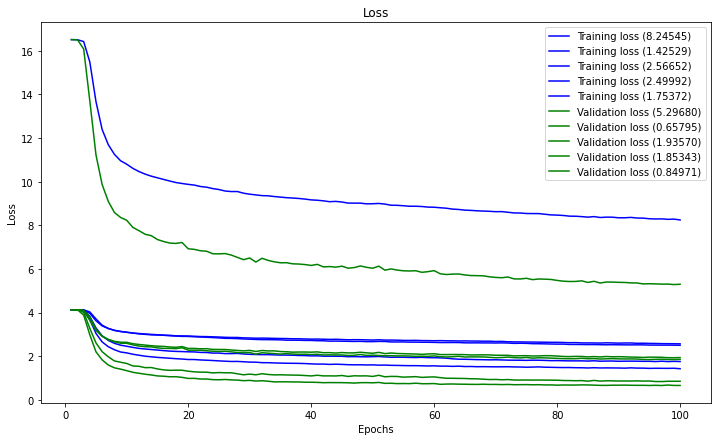

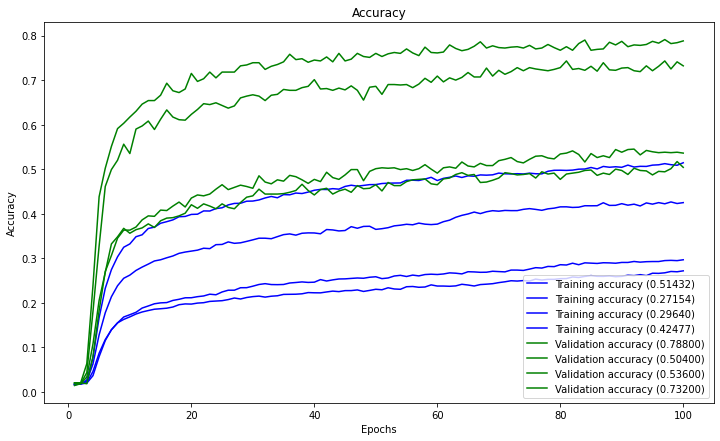

In [15]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    plt.figure(figsize=(12,7))
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(figsize=(12,7))
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
plot_history(history)

In [16]:
model.evaluate(val_dataset)

1/1 [==============================] - 1s 1s/step - loss: 5.2968 - dense_1_loss: 0.6579 - dense_3_loss: 1.9357 - dense_5_loss: 1.8534 - dense_7_loss: 0.8497 - dense_1_accuracy: 0.7880 - dense_3_accuracy: 0.5040 - dense_5_accuracy: 0.5360 - dense_7_accuracy: 0.7320


[5.296796798706055,
 0.6579470038414001,
 1.9357049465179443,
 1.8534313440322876,
 0.8497132658958435,
 0.7879999876022339,
 0.5040000081062317,
 0.5360000133514404,
 0.7319999933242798]

In [22]:
test_dataset = load_dataset('test')
test_img_batch, test_text_batch = next(iter(test_dataset.take(1)))
print(test_img_batch.shape, len(test_text_batch), test_text_batch[0].shape)
predictions = model.predict(test_img_batch)
print(len(predictions), predictions[0].shape, len(test_text_batch), test_text_batch[3].shape)
test_text_batch = np.array(test_text_batch)
for i in range(test_text_batch.shape[1]):        
        c_s = test_text_batch[:, i]
        real_text = ''
        pred_text = ''
        for c_i, c_ in enumerate(c_s):
            real_c = vec2text(c_)
            real_text += real_c
            pred_c = vec2text(np.array(predictions)[:, i][c_i])
            pred_text += pred_c
        print('real text: {}, pred_text: {}'.format(real_text, pred_text))
        


(1000, 60, 160, 3) 4 (1000, 62)
4 (1000, 62) 4 (1000, 62)
real text: yZfR, pred_text: yzZR
real text: VyDu, pred_text: vyDU
real text: x7Fs, pred_text: x7Es
real text: JwMp, pred_text: JMMp
real text: phvm, pred_text: phNm
real text: AFBj, pred_text: ARDl
real text: 4RRT, pred_text: hRRT
real text: DwTw, pred_text: 0wnw
real text: JKEJ, pred_text: JKEJ
real text: aCIi, pred_text: aCII
real text: Tskt, pred_text: TSft
real text: PxiS, pred_text: PXis
real text: jKkA, pred_text: jKkA
real text: HZig, pred_text: Hcig
real text: NP7A, pred_text: NP2A
real text: EhIF, pred_text: EhiF
real text: Qz48, pred_text: QQd8
real text: ZiXP, pred_text: zixP
real text: 7cOO, pred_text: 1GCO
real text: YnlI, pred_text: YrQQ
real text: AucG, pred_text: AucG
real text: goMz, pred_text: gg0q
real text: 5B3Y, pred_text: T5BH
real text: JZjY, pred_text: JZjY
real text: xzn0, pred_text: xzoQ
real text: rsoJ, pred_text: rSQU
real text: w2DR, pred_text: w2QR
real text: Lbki, pred_text: Lkki
real text: 8YW2, p

real text: rx5n, pred_text: nX5n
real text: 94D9, pred_text: 9k09
real text: dAvN, pred_text: dNWN
real text: eVf0, pred_text: evfO
real text: CGZu, pred_text: CGzU
real text: GLVY, pred_text: GLvy
real text: STFW, pred_text: STFW
real text: zsCq, pred_text: ZSCq
real text: KfC2, pred_text: KfC2
real text: UwKd, pred_text: uUMb
real text: MWRG, pred_text: WMRG
real text: 8o4s, pred_text: 8D4s
real text: TmEg, pred_text: TmEg
real text: gRsF, pred_text: g89F
real text: uIAc, pred_text: ulAC
real text: c0YP, pred_text: cOYP
real text: 5Agh, pred_text: 5sgh
real text: D5qa, pred_text: o5qa
real text: fqDr, pred_text: tq0r
real text: 1AUi, pred_text: 1uUi
real text: rk51, pred_text: rk51
real text: tJyO, pred_text: iJy0
real text: dYGe, pred_text: d6se
real text: UUkD, pred_text: Luko
real text: gUM2, pred_text: gM42
real text: 2HaJ, pred_text: 2HaJ
real text: bSmY, pred_text: b3mY
real text: Jw0n, pred_text: JvDn
real text: Tfaf, pred_text: 1fBf
real text: k3LU, pred_text: F8LU
real text:

In [18]:
texts = np.array(test_text_batch)
print(texts.shape)
print(texts[:,0,:60].shape)
texts[1, 0, :].shape

(4, 1000, 62)
(4, 60)


(62,)

In [19]:
model.save('captcha_identify.h5')